# Image Segmentation

1. Visualize data/perform some exploratory data analysis
2. Set up data pipeline and preprocessing
3. Build model
4. Train model
5. Evaluate model
6. Repeat

## Project Description

### Task
* Polyp segmentation from colonoscopy image by using GIANA dataset
* This code is borrowed from [TensorFlow tutorials/Image Segmentation](https://github.com/tensorflow/models/blob/master/samples/outreach/blogs/segmentation_blogpost/image_segmentation.ipynb) which is made of `tf.keras.layers`.
* You can see the detail description [tutorial link](https://github.com/tensorflow/models/blob/master/samples/outreach/blogs/segmentation_blogpost/image_segmentation.ipynb)  

### Dataset
* [Gastrointestinal Image ANAlys Challenges (GIANA)](https://giana.grand-challenge.org) Dataset (345MB)
  * Train data: 300 images with RGB channels (bmp format)
  * Train lables: 300 images with 1 channels (bmp format)
  * Image size: 574 x 500
* Resize **image size to 256** when training

### Baseline code
* Input data shape: (`batch_size`, 256, 256, 3)
* Output data shape: (`batch_size`, 256, 256, 1)
* Architecture: 
  * Encoder-Decoder
* Training
* Evaluation
  * MeanIOU
  * tf.version 2.0 API: [`tf.keras.metrics.MeanIoU`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/metrics/MeanIoU)

## Import modules

### Import colab modules for Google Colab (if necessary)

In [ ]:
!pip install tensorflow-gpu==2.1

     |████████████████████████████████| 421.8MB 24kB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
     |████████████████████████████████| 450kB 54.3MB/s 
     |████████████████████████████████| 3.9MB 50.5MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=1d8457ceea4819edec6fca49ce601de7941d4733a46181922f72764b0bc6d4df
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.3.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 2.1.1 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorflow-estimator<2.4.0,>=2.3.0, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing ins

In [ ]:
use_colab = True
assert use_colab in [True, False]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import base modules

In [ ]:
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

import os
import time
import shutil
import functools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)

from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models

2.1.0


# Model Selection
* Will only use u-net model in this file

In [ ]:
is_train = True

model_name = 'u-net'
assert model_name in ['ed_model', 'u-net']

## Data Collection and Visualization

### Download data

This project will use [Giana Dataset](https://giana.grand-challenge.org/Dates/).

In [ ]:
if use_colab:
    DATASET_PATH='./drive/My Drive/datasets/'
else:
    DATASET_PATH='../../datasets/'

if not os.path.isdir(DATASET_PATH):
    os.makedirs(DATASET_PATH)

    import urllib.request
    u = urllib.request.urlopen(url='http://bigfile.mail.naver.com/bigfileupload/download?fid=8YbZaAIq1NKdKxbjK3YXFq2/HqUmKogmFogrKxUwKqKdHqu9axtmFAb9axvjKo2Zaxt/FAioM4traAb/MquXpovlKq0SMxUrpA0SF4M=')
    data = u.read()
    u.close()

    with open('sd_train.zip', "wb") as f :
        f.write(data)
        print('Data has been downloaded')

    shutil.move(os.path.join('sd_train.zip'), os.path.join(DATASET_PATH))
    file_path = os.path.join(DATASET_PATH, 'sd_train.zip')

    import zipfile
    zip_ref = zipfile.ZipFile(file_path, 'r')
    zip_ref.extractall(DATASET_PATH)
    zip_ref.close()
    print('Data has been extracted.')
    
else:
    print('Data has already been downloaded and extracted.')

Data has already been downloaded and extracted.


### Split dataset into train data and test data

In [ ]:
dataset_dir = os.path.join(DATASET_PATH, 'sd_train')

img_dir = os.path.join(dataset_dir, "train")
label_dir = os.path.join(dataset_dir, "train_labels")

In [ ]:
x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()

In [ ]:
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2, random_state=219)

In [ ]:
num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 480
Number of test examples: 120


### Visualize


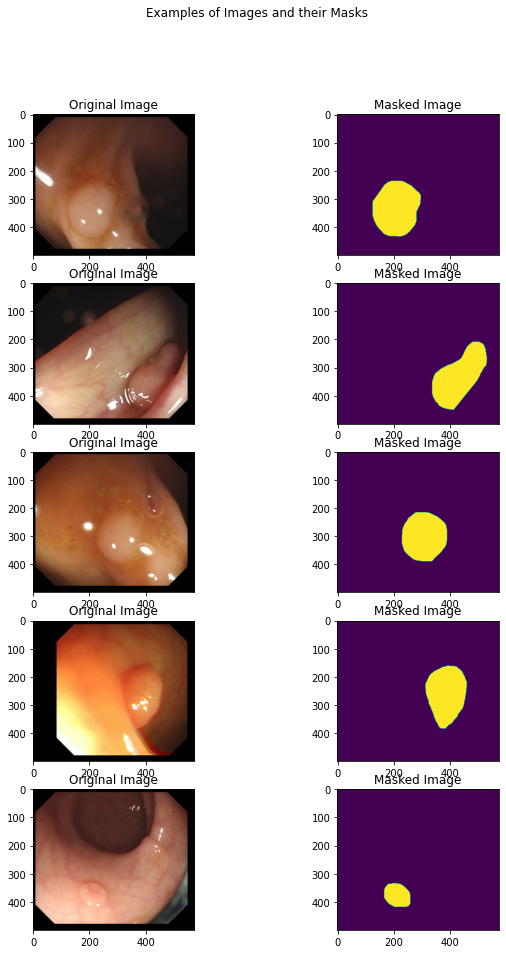

In [ ]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]
    x_pathname = x_train_filenames[img_num]
    y_pathname = y_train_filenames[img_num]

    plt.subplot(display_num, 2, i + 1)
    plt.imshow(Image.open(x_pathname))
    plt.title("Original Image")

    example_labels = Image.open(y_pathname)
    label_vals = np.unique(example_labels)

    plt.subplot(display_num, 2, i + 2)
    plt.imshow(example_labels)
    plt.title("Masked Image")
    
plt.suptitle("Examples of Images and their Masks")
plt.show()

## Data pipeline and preprocessing

### Set up hyper-parameters

In [ ]:
# Set hyperparameters
image_size = 256
img_shape = (image_size, image_size, 3)
batch_size = 32
max_epochs = 150

if use_colab:
    checkpoint_dir ='./drive/My Drive/train_ckpt/segmentation/exp1'
    if not os.path.isdir(checkpoint_dir):
        os.makedirs(checkpoint_dir)
else:
    checkpoint_dir = './train_ckpt/segmentation/exp1'

### Build our input pipeline with `tf.data`

> 1. Read the bytes from file name. 
> 2. Decode the bytes to image type
> 3. Apply image transformations : 
> * `resize`
> * `hue_delta`
> * `horizontal_flip`
> * `width_shift_range`, `height_shift_range`
> * `rescale`
> 4. Mix the data, repeat the training.

#### Why do we do these image transformations?

> This is known as **data augmentation**. Data augmentation "increases" the amount of training data by augmenting them via a number of random transformations. During training time, our model would never see twice the exact same picture. This helps prevent [overfitting](https://developers.google.com/machine-learning/glossary/#overfitting) and helps the model generalize better to unseen data.

#### Processing each pathname

In [ ]:
def _process_pathnames(fname, label_path):
    # We map this function onto each pathname pair
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_bmp(img_str, channels=3) # RGB

    label_img_str = tf.io.read_file(label_path)
    label_img = tf.image.decode_bmp(label_img_str, channels=1) # BMP 0,1

    resize = [image_size, image_size]
    img = tf.image.resize(img, resize)
    label_img = tf.image.resize(label_img, resize)

    scale = 1 / 255.
    img = tf.cast(img, dtype=tf.float32) * scale
    label_img = tf.cast(label_img, dtype=tf.float32) * scale

    return img, label_img

#### Shifting the image

In [ ]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """This fn will perform the horizontal or vertical shift"""
    if width_shift_range or height_shift_range:
        if width_shift_range:
                width_shift_range = tf.random.uniform([],
                                                  -width_shift_range * img_shape[1],
                                                  width_shift_range * img_shape[1])
        if height_shift_range:
                height_shift_range = tf.random.uniform([],
                                                   -height_shift_range * img_shape[0],
                                                   height_shift_range * img_shape[0])
        output_img = tfa.image.translate(output_img,
                                         [width_shift_range, height_shift_range])
        label_img = tfa.image.translate(label_img,
                                        [width_shift_range, height_shift_range])
    return output_img, label_img

#### Flipping the image randomly

In [ ]:
def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
    return tr_img, label_img

#### Assembling our transformations into our augment function

In [ ]:
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0.01,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=True,  # Random left right flip,
             width_shift_range=.1,  # Randomly translate the image horizontally
             height_shift_range=.1):  # Randomly translate the image vertically 
    if resize is not None:
        # Resize both images
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)
  
    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)
  
    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale
    return img, label_img

In [ ]:
def get_baseline_dataset(filenames,
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=4,
                         batch_size=batch_size,
                         is_train=True):
    num_x = len(filenames)
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)

    if is_train:
        dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
        dataset = dataset.shuffle(num_x * 10)

    dataset = dataset.batch(batch_size)
    return dataset

### Set up train and test datasets
Note that we apply image augmentation to our training dataset but not our validation dataset.

In [ ]:
train_dataset = get_baseline_dataset(x_train_filenames, 
                                     y_train_filenames) 
test_dataset = get_baseline_dataset(x_test_filenames,
                                    y_test_filenames,
                                    is_train=False)

In [ ]:
train_dataset

<BatchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>

### Plot some train data

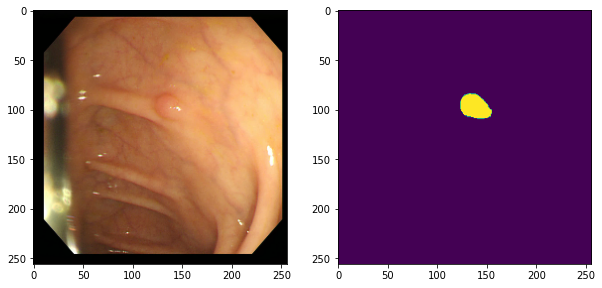

In [ ]:
for images, labels in train_dataset.take(1):
    # Running next element in our graph will produce a batch of images
    plt.figure(figsize=(10, 10))
    img = images[0]

    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(labels[0, :, :, 0])
    plt.show()

## Build the model

Will only make U-Net model in this file.
* [U-Net](https://arxiv.org/abs/1505.04597)

### U-Net architecture

<img src='https://user-images.githubusercontent.com/11681225/58005153-fd934300-7b1f-11e9-9ad8-a0e9186e751c.png' width="800">

>We'll build the U-Net model. U-Net is especially good with segmentation tasks because it can localize well to provide high resolution segmentation masks. In addition, it works well with small datasets and is relatively robust against overfitting as the training data is in terms of the number of patches within an image, which is much larger than the number of training images itself. Unlike the original model, we will add batch normalization to each of our blocks. 

>The Unet is built with an encoder portion and a decoder portion. The encoder portion is composed of a linear stack of [`Conv`](https://developers.google.com/machine-learning/glossary/#convolution), `BatchNorm`, and [`Relu`](https://developers.google.com/machine-learning/glossary/#ReLU) operations followed by a [`MaxPool`](https://developers.google.com/machine-learning/glossary/#pooling). Each `MaxPool` will reduce the spatial resolution of our feature map by a factor of 2. We keep track of the outputs of each block as we feed these high resolution feature maps with the decoder portion. The Decoder portion is comprised of UpSampling2D, Conv, BatchNorm, and Relus. Note that we concatenate the feature map of the same size on the decoder side. Finally, we add a final Conv operation that performs a convolution along the channels for each individual pixel (kernel size of (1, 1)) that outputs our final segmentation mask in grayscale. 

#### The `tf.keras` Functional API

In [ ]:
if model_name == 'u-net':
    class Conv(tf.keras.Model):
        def __init__(self, num_filters, kernel_size):
            super(Conv, self).__init__()
            self.conv = layers.Conv2D(num_filters, kernel_size, padding='same')
            self.bn = layers.BatchNormalization()

        def call(self, inputs, training=True):
            x = self.conv(inputs)
            x = self.bn(x)
            x = layers.ReLU()(x)

            return x

In [ ]:
if model_name == 'u-net':
    class ConvBlock(tf.keras.Model):
        def __init__(self, num_filters):
            super(ConvBlock, self).__init__()
            self.conv1 = Conv(num_filters, 3) # Conv class
            self.conv2 = Conv(num_filters, 3) # Conv class

        def call(self, inputs, training=True):
            encoder = self.conv1(inputs) # conv1
            encoder = self.conv2(encoder) # conv2

            return encoder
    
    class ConvBlock_R(tf.keras.Model):
        def __init__(self, num_filters):
            super(ConvBlock_R, self).__init__()
            self.conv1 = Conv(num_filters, 3) # Conv class 
            self.conv2 = Conv(num_filters, 3) # Conv class

        def call(self, inputs, training=True):
            decoder = self.conv1(inputs) # conv1
            decoder = self.conv2(decoder) # conv2

            return decoder


    class EncoderBlock(tf.keras.Model):
        def __init__(self, num_filters):
            super(EncoderBlock, self).__init__()
            self.conv_block = ConvBlock(num_filters) # Conv block
            self.encoder_pool = layers.MaxPool2D() # max pool

        def call(self, inputs, d=0, training=True):
            encoder = self.conv_block(inputs) # conv block
            if d:
              encoder = layers.Dropout(d)(encoder)
            encoder_pool = self.encoder_pool(encoder) # encoder pool

            return encoder_pool, encoder


    class DecoderBlock(tf.keras.Model):
        def __init__(self, num_filters):
            super(DecoderBlock, self).__init__()
            self.convT = layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same') # conv transpose
            self.bn = layers.BatchNormalization() # batch norm
            self.conv_block_r = ConvBlock_R(num_filters) # convblock R

        def call(self, input_tensor, concat_tensor, training=True):
            # convT - bn - relu - concat - conv black R
            decoder = self.convT(input_tensor)
            decoder = self.bn(decoder)
            decoder = layers.ReLU()(decoder)
            decoder = tf.concat([decoder, concat_tensor], -1)
            decoder = self.conv_block_r(decoder)

            return decoder

In [ ]:
if model_name == 'u-net':
    class UNet(tf.keras.Model):
        def __init__(self):
            super(UNet, self).__init__()
            self.encoder_block1 = EncoderBlock(32) # encoder 32
            self.encoder_block2 = EncoderBlock(64) # encoder 64
            self.encoder_block3 = EncoderBlock(128) # encoder 128
            self.encoder_block4 = EncoderBlock(256) # encoder 256

            self.center = ConvBlock(512) # conv block 512

            self.decoder_block4 = DecoderBlock(256) # decoder 256
            self.decoder_block3 = DecoderBlock(128) # decoder 128
            self.decoder_block2 = DecoderBlock(64) # decoder 64
            self.decoder_block1 = DecoderBlock(32) # decoder 32

            self.output_conv = layers.Conv2D(1, 1, padding='same', activation='sigmoid') # a output layer conv2d

        def call(self, inputs, training=True):
            encoder1_pool, encoder1 = self.encoder_block1(inputs, d=0.25) # encoder1 outputs
            encoder2_pool, encoder2 = self.encoder_block2(encoder1_pool) # encoder2 outputs
            encoder3_pool, encoder3 = self.encoder_block3(encoder2_pool, d=0.25) # encoder3 outputs
            encoder4_pool, encoder4 = self.encoder_block4(encoder3_pool) # encoder4 outputs

            center = self.center(encoder4_pool) # center outputs

            decoder4 = self.decoder_block4(center, encoder4) # decoder4 output
            decoder3 = self.decoder_block3(decoder4, encoder3) # decoder3 output
            decoder2 = self.decoder_block2(decoder3, encoder2) # decoder2 output
            decoder1 = self.decoder_block1(decoder2, encoder1) # decoder1 output

            decoder1 = layers.Dropout(0.4)(decoder1)
            outputs = self.output_conv(decoder1)
            return outputs

#### Create a U-Net model

In [ ]:
if model_name == 'u-net':
    unet_model = UNet()

### Defining custom metrics and loss functions

[Dice coefficient](http://campar.in.tum.de/pub/milletari2016Vnet/milletari2016Vnet.pdf)

$$D = \frac{2 \sum_{i}^{N} p_{i}g_{i}}{\sum_{i}^{N} p_{i}^{2} + \sum_{i}^{N} g_{i}^{2}}$$
$p_i$ : predicted binary segmentation volume, $g_i$ : ground truth binary volume

About dice loss

>Defining loss and metric functions are simple with Keras. Simply define a function that takes both the True labels for a given example and the Predicted labels for the same given example.

>Dice loss is a metric that measures overlap. More info on optimizing for Dice coefficient (our dice loss) can be found in the [paper](http://campar.in.tum.de/pub/milletari2016Vnet/milletari2016Vnet.pdf), where it was introduced.

>We use dice loss here because it performs better at class imbalanced problems by design. In addition, maximizing the dice coefficient and IoU metrics are the actual objectives and goals of our segmentation task. Using cross entropy is more of a proxy which is easier to maximize. Instead, we maximize our objective directly.

In [ ]:
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)

    return score

In [ ]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

Here, we'll use a specialized loss function that combines binary cross entropy and our dice loss. This is based on [individuals who competed within this competition obtaining better results empirically](https://www.kaggle.com/c/carvana-image-masking-challenge/discussion/40199). Try out your own custom losses to measure performance (e.g. bce + log(dice_loss), only bce, etc.)!

In [ ]:
def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + \
          dice_loss(y_true, y_pred)
    return loss

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-3)

### Select a model

In [ ]:
if model_name == 'ed_model':
    print('select the Encoder-Decoder model')
    model = ed_model

if model_name == 'u-net':
    print('select the U-Net model')
    model = unet_model

select the U-Net model


### Compile

In [ ]:
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions = model(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)

(32, 256, 256, 1)


In [ ]:
model.summary()

Model: "u_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_block (EncoderBlock) multiple                  10400     
_________________________________________________________________
encoder_block_1 (EncoderBloc multiple                  55936     
_________________________________________________________________
encoder_block_2 (EncoderBloc multiple                  222464    
_________________________________________________________________
encoder_block_3 (EncoderBloc multiple                  887296    
_________________________________________________________________
conv_block_4 (ConvBlock)     multiple                  3544064   
_________________________________________________________________
decoder_block (DecoderBlock) multiple                  2952960   
_________________________________________________________________
decoder_block_1 (DecoderBloc multiple                  739200

### Checkpoints

In [ ]:
if not tf.io.gfile.exists(checkpoint_dir):
    tf.io.gfile.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
if is_train:
    checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                   model=model)
else:
    checkpoint = tf.train.Checkpoint(model=model)

## Train your model

In [ ]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        plt.figure(figsize=(10, 20))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[0,: , :, :])
        plt.title("Input image")

        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[0, :, :, 0])
        plt.title("Actual Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, :, :, 0])
        plt.title("Predicted Mask")
        plt.show()

### Training - `tf.GradientTape()`

Epochs: 150.00 global_step: 2250 loss: 0.048 (27.36 examples/sec; 1.169 sec/batch)


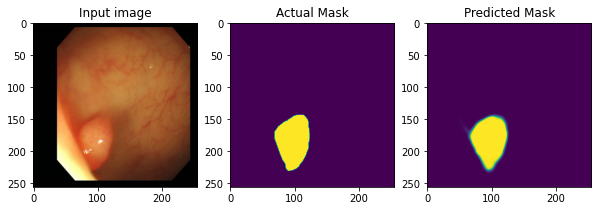

In [ ]:
# save loss values for plot
loss_history = []
global_step = 0 
print_steps = 10 # tf.gradient_tape
save_epochs = max_epochs // 2 # tf.gradient_tape

for epoch in range(max_epochs):
    for images, labels in train_dataset: 
        start_time = time.time()
        global_step = global_step + 1
        
        with tf.GradientTape() as tape: 
            predictions = model(images, training=True) # [batch_size, 256,256,3]
            # [batch_size, 256, 256, 1] - prediction
            loss = bce_dice_loss(labels, predictions) # label [batch_size, 256, 256, 1]
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        epochs = global_step * batch_size / float(num_train_examples)
        duration = time.time() - start_time
        if global_step % print_steps == 0:
            clear_output(wait=True)
            examples_per_sec = batch_size  / float(duration)
            print("Epochs: {:.2f} global_step: {} loss: {:.3f} ({:.2f} examples/sec; {:.3f} sec/batch)".format(
                        epochs, global_step, loss, examples_per_sec, duration))

            loss_history.append([epoch, loss])

            # print sample image
            for test_images, test_labels in test_dataset.take(1):
                predictions = model(test_images)
        
            plt.figure(figsize=(10, 20))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[0,: , :, :])
            plt.title("Input image")
            
            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[0, :, :, 0])
            plt.title("Actual Mask")
                
            plt.subplot(1, 3, 3)
            plt.imshow(predictions[0, :, :, 0])
            plt.title("Predicted Mask")
            plt.show()

    if (epoch+1) % save_epochs == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

### Plot the loss

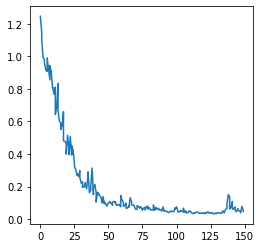

In [ ]:
loss_history = np.asarray(loss_history)
plt.figure(figsize=(4, 4))
plt.plot(loss_history[:,0], loss_history[:,1])
plt.show()

## Restore the latest checkpoint

In [ ]:
if not is_train:
    # restoring the latest checkpoint in checkpoint_dir
    model.load_weights(checkpoint_dir)

## Evaluate the test dataset

In [ ]:
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten  
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

In [ ]:
# mean = tf.keras.metrics.Mean("mean_iou")
mean = []

for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))

mean_iou: 0.9058627770270411


In [ ]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        for i in range(batch_size):
            plt.figure(figsize=(10, 20))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[i,: , :, :])
            plt.title("Input image")

            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title("Actual Mask")

            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i, :, :, 0])
            plt.title("Predicted Mask")
            plt.show()

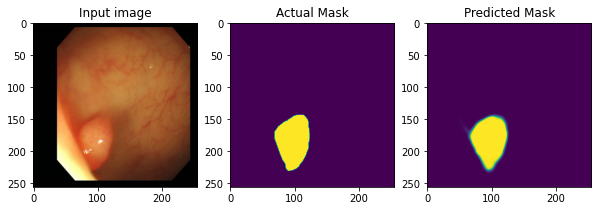

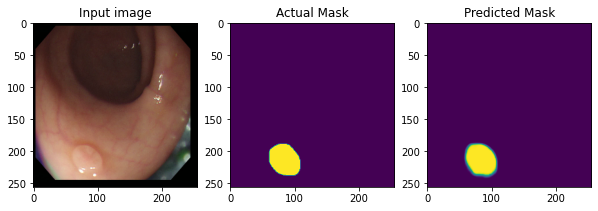

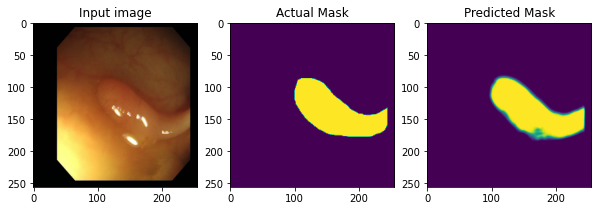

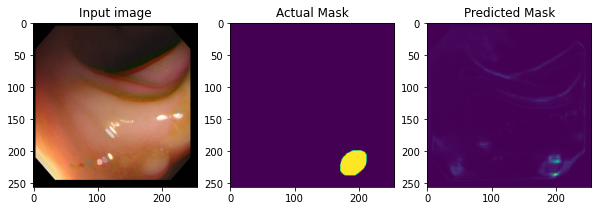

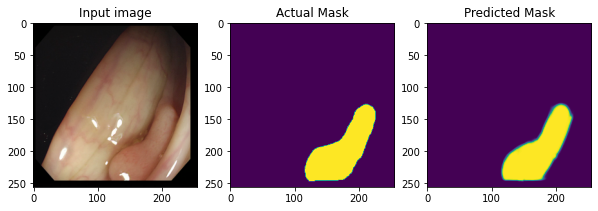

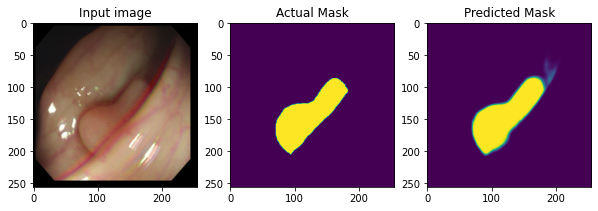

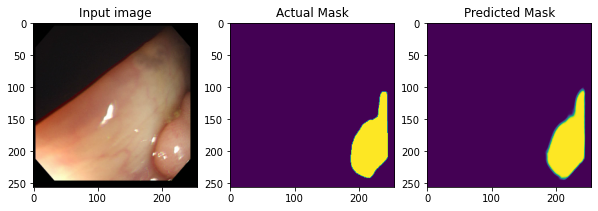

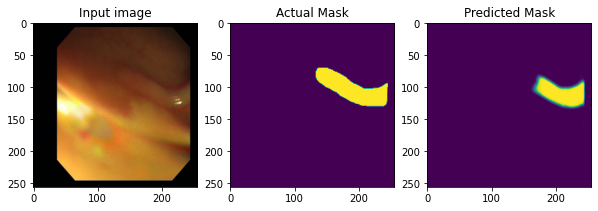

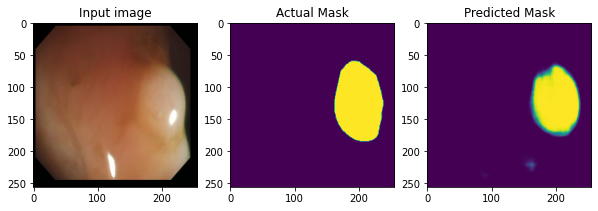

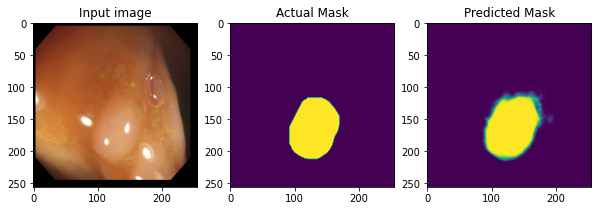

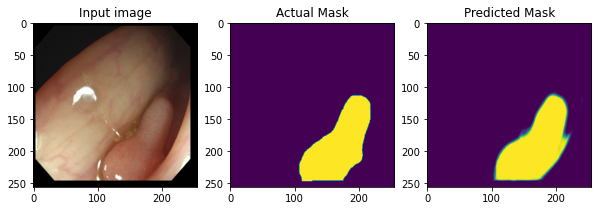

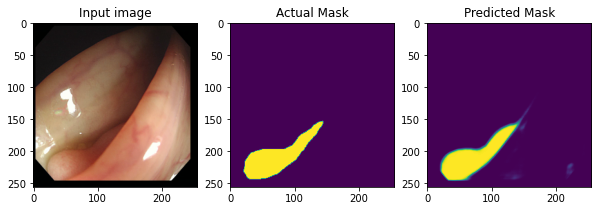

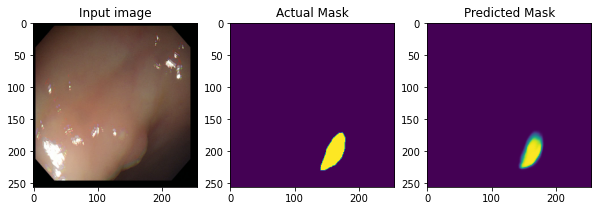

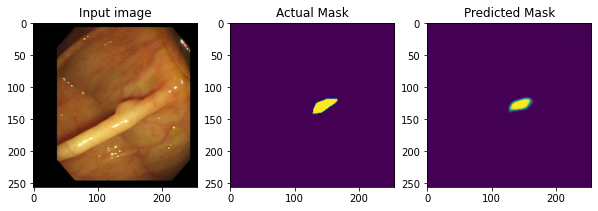

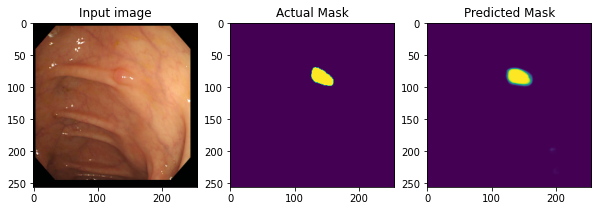

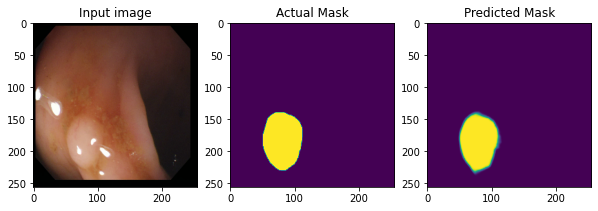

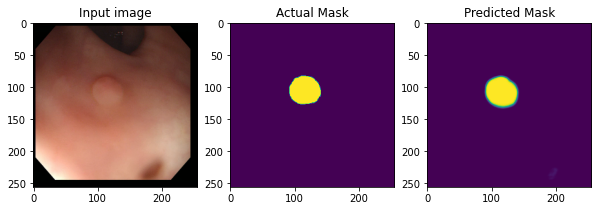

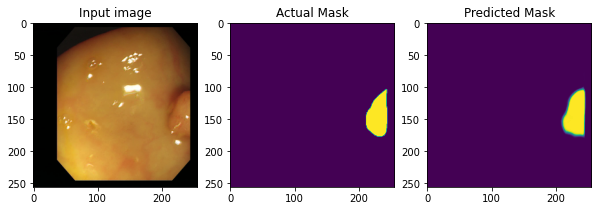

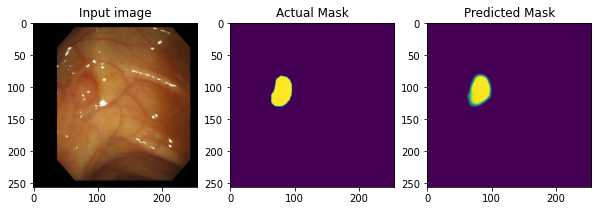

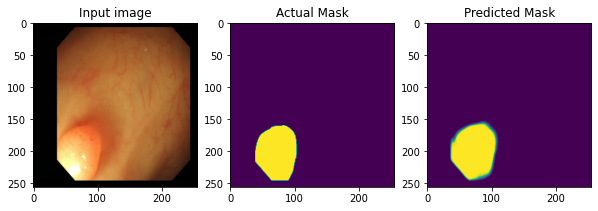

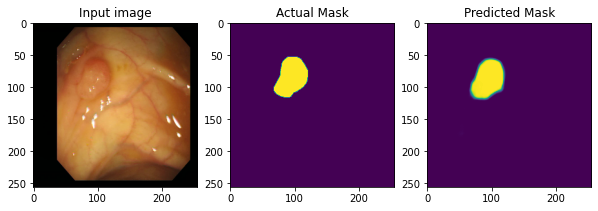

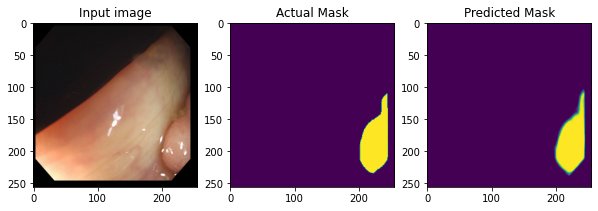

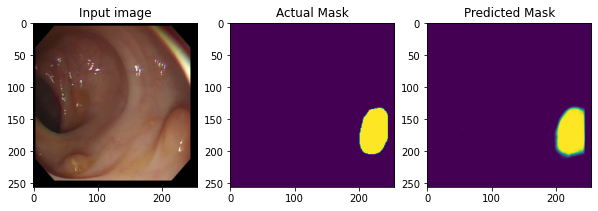

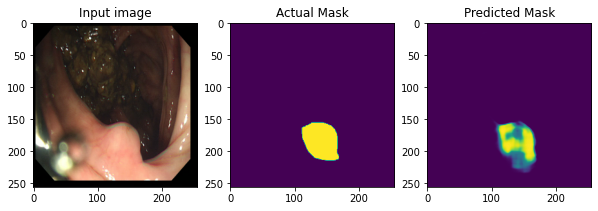

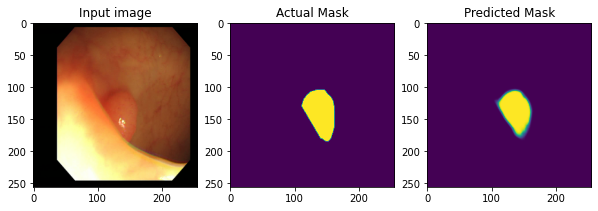

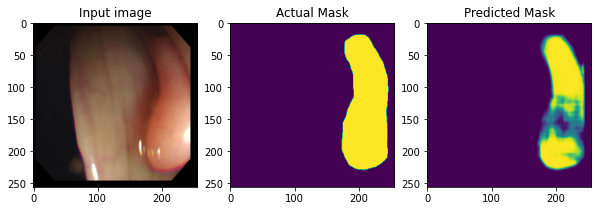

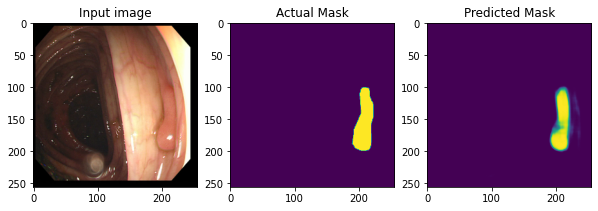

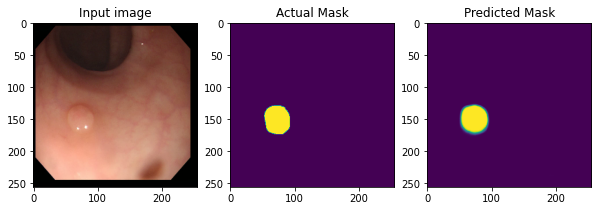

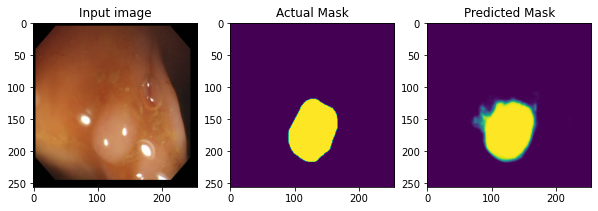

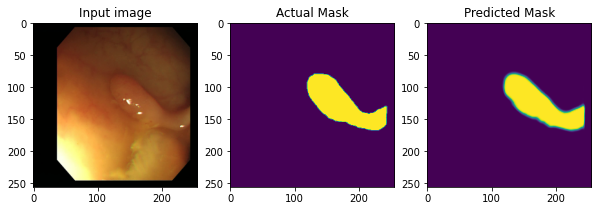

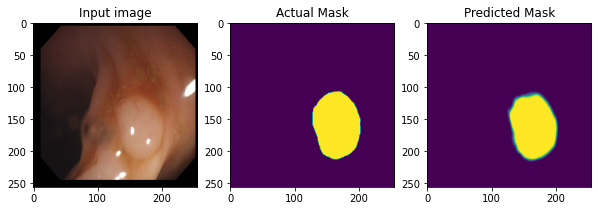

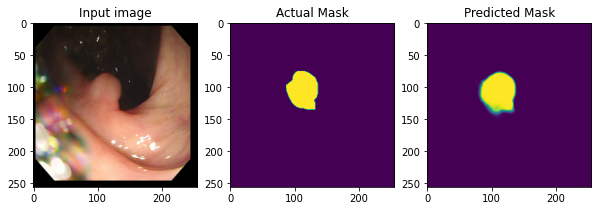

In [ ]:
print_images()